# ML: Baseline and tuned SVM

In [3]:
# Library imports
import pickle
import numpy as np
import pandas as pd
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split

### Load and prepare for classification(map target)

In [4]:
# Load the data
train_df = pd.read_csv("../data/louis_ck_train_auto_labeled.csv")
val_df = pd.read_csv("../data/louis_ck_val_auto_labeled.csv")
test_df = pd.read_csv("../data/louis_ck_test_auto_labeled.csv")

# encode binary labels to 0 and 1
label_map = {'non_irony': 0, 'irony': 1}

train_df['label_binary'] = train_df['irony_sarcasm_label'].map(label_map)
test_df['label_binary'] = test_df['irony_sarcasm_label'].map(label_map)
val_df['label_binary'] = val_df['irony_sarcasm_label'].map(label_map)

### Vectorize and split

In [5]:
# label columns clean up
train_df['irony_sarcasm_label'] = train_df['irony_sarcasm_label'].str.lower().str.strip()
val_df['irony_sarcasm_label'] = val_df['irony_sarcasm_label'].str.lower().str.strip()
test_df['irony_sarcasm_label'] = test_df['irony_sarcasm_label'].str.lower().str.strip()

# vectorization
vectorizer = TfidfVectorizer(
    lowercase=True,
    max_features=10000,
    ngram_range=(1, 2)
)

X_train = vectorizer.fit_transform(train_df['context_window'])
X_val = vectorizer.transform(val_df['context_window'])
X_test = vectorizer.transform(test_df['context_window'])

y_train = train_df['label_binary']
y_val = val_df['label_binary']
y_test = test_df['label_binary']

### Run the baseline model

In [6]:
# model training
baseline_model = SVC(kernel='linear', probability=True, class_weight='balanced') 
baseline_model.fit(X_train, y_train)

# check on validation set
y_val_pred = baseline_model.predict(X_val)
print(classification_report(y_val, y_val_pred, target_names=['none', 'sarcasm_irony']))

# test set evaluation
y_test_pred = baseline_model.predict(X_test)
print("Test Set Evaluation:")
print(classification_report(y_test, y_test_pred, target_names=['none', 'sarcasm_irony']))

               precision    recall  f1-score   support

         none       0.98      0.91      0.94       310
sarcasm_irony       0.49      0.85      0.62        33

     accuracy                           0.90       343
    macro avg       0.74      0.88      0.78       343
 weighted avg       0.94      0.90      0.91       343

Test Set Evaluation:
               precision    recall  f1-score   support

         none       0.99      0.91      0.95       322
sarcasm_irony       0.40      0.86      0.55        22

     accuracy                           0.91       344
    macro avg       0.70      0.89      0.75       344
 weighted avg       0.95      0.91      0.92       344



### Save the baseline model

In [7]:
# save the baseline SVC model
with open("../models/svm_model_baseline.pkl", "wb") as file:
    pickle.dump(baseline_model, file)

print("Baseline model saved using pickle as svm_model_baseline.pkl")


# save the vectorizer
with open("../models/tfidf_vectorizer.pkl", "wb") as file:
    pickle.dump(vectorizer, file)
print("TfidfVectorizer saved using pickle as tfidf_vectorizer.pkl")


Baseline model saved using pickle as svm_model_baseline.pkl
TfidfVectorizer saved using pickle as tfidf_vectorizer.pkl


# Hyperparameter tuning: SVM

In [8]:
# pipeline: vectorizer, SVM
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
                lowercase=True,
                stop_words='english'
            )),
    ('svc', SVC(probability=True, class_weight='balanced'))
])

# Define parameter grid for hyperparameter tuning:
param_grid = {
    # TfidfVectorizer hyperparameters
    'tfidf__max_features': [5000, 10000],
    'tfidf__ngram_range': [(1, 1), (1, 2)],

    # SVC hyperparameters
    'svc__C': [0.1, 1, 10],
    'svc__kernel': ['linear', 'rbf', 'poly'],
    # 'gamma' is relevant for 'rbf', 'poly', or 'sigmoid' kernels
    'svc__gamma': ['scale', 'auto'],
    # Only when kernel is 'poly'; set some values to try
    'svc__degree': [2, 3]
}

# Instantiate GridSearchCV for cross-validation
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,            # 5-fold cross-validation
    n_jobs=-1,       # use all processors
    verbose=2,
    scoring='f1'     # adjust scoring metric as needed
)

# Fit GridSearchCV on your training data
grid_search.fit(train_df['context_window'], train_df['label_binary'])

# Print best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

# Evaluate on the test set:
y_test_pred = grid_search.predict(test_df['context_window'])
print("Test Set Evaluation:")
print(classification_report(test_df['label_binary'], y_test_pred, target_names=['none_irony', 'irony']))

Fitting 5 folds for each of 144 candidates, totalling 720 fits
Best Parameters: {'svc__C': 10, 'svc__degree': 2, 'svc__gamma': 'scale', 'svc__kernel': 'rbf', 'tfidf__max_features': 5000, 'tfidf__ngram_range': (1, 1)}
Best Cross-Validation Score: 0.706067020761328
Test Set Evaluation:
              precision    recall  f1-score   support

  none_irony       0.97      0.98      0.97       322
       irony       0.62      0.59      0.60        22

    accuracy                           0.95       344
   macro avg       0.80      0.78      0.79       344
weighted avg       0.95      0.95      0.95       344



### Save the model

In [9]:
best_model = grid_search.best_estimator_

# Save the best hyperparameter tuned model to a file
with open("../models/svm_model_tuned.pkl", "wb") as file:
    pickle.dump(best_model, file)

print("Best hyper-tuned model saved as svm_model_tuned.pkl")


Best hyper-tuned model saved as svm_model_tuned.pkl


# Visualizations

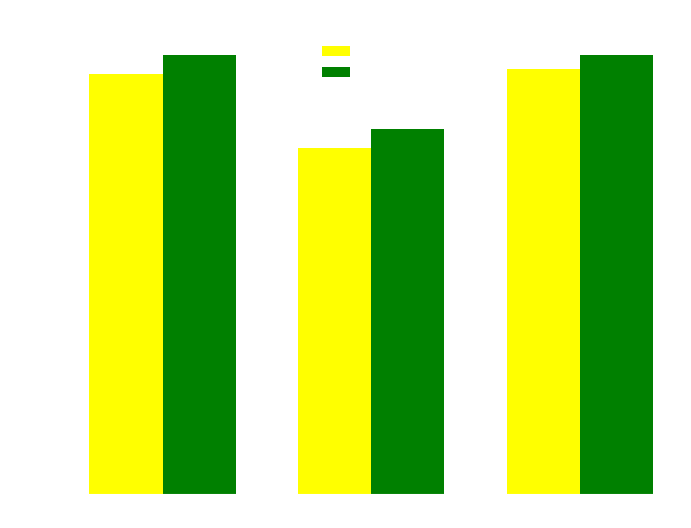

In [10]:
overall_metrics_baseline = {
    'Accuracy': 0.91,
    'Macro Avg F1': 0.75,
    'Weighted Avg F1': 0.92
}
overall_metrics_tuned = {
    'Accuracy': 0.95,
    'Macro Avg F1': 0.79,
    'Weighted Avg F1': 0.95
}

# Prepare data for plotting
metrics = list(overall_metrics_baseline.keys())
x = np.arange(len(metrics))   # positions along x-axis
width = 0.35                  # width of the bars

# Create a figure and axes with a transparent background
fig, ax = plt.subplots(figsize=(8, 6), facecolor='none')
ax.set_facecolor('none')  # leave the axes background transparent

# Plot the bars using yellow for baseline and green for tuned
baseline_values = [overall_metrics_baseline[m] for m in metrics]
tuned_values = [overall_metrics_tuned[m] for m in metrics]

bars_baseline = ax.bar(x - width/2, baseline_values, width, label='Baseline', color='yellow')
bars_tuned = ax.bar(x + width/2, tuned_values, width, label='Tuned', color='green')

# Set x-ticks and labels with white font color
ax.set_xticks(x)
ax.set_xticklabels(metrics, color='white')
ax.set_ylim(0, 1)

# Set axis labels and title with white color
ax.set_ylabel("Score", color='white')
ax.set_title("Overall Model Performance Metrics", color='white')

# Customize tick parameters so ticks and tick labels are white
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')

# Set the color of the axis spines to white
for spine in ax.spines.values():
    spine.set_edgecolor('white')

# Create and customize the legend, then update legend text colors to white
legend = ax.legend(facecolor='none', edgecolor='white')
for text in legend.get_texts():
    text.set_color("white")

# Save the figure as a PNG with a transparent background
plt.savefig("../plots/overall_metrics_dark_green.png", dpi=300, bbox_inches='tight', transparent=True)
plt.show()


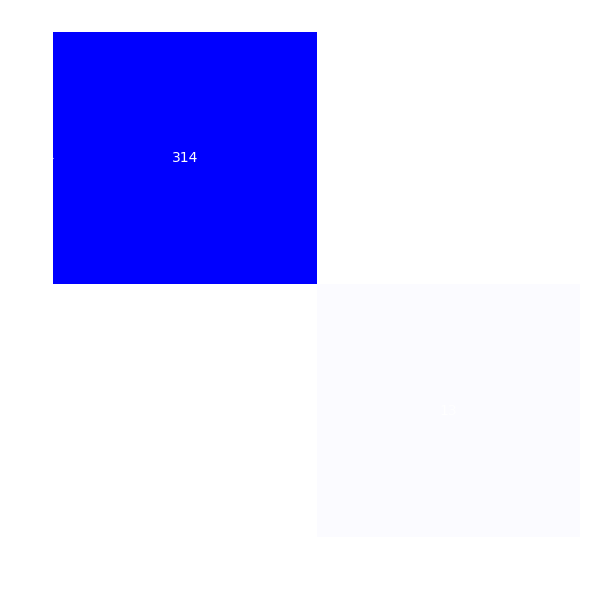

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

# Define custom colormaps that transition from white to the desired color
yellow_cmap = LinearSegmentedColormap.from_list("custom_yellow", ["white", "yellow"])
green_cmap = LinearSegmentedColormap.from_list("custom_green", ["white", "blue"])

# Approximate confusion matrices based on your earlier results
# Using consistent class labels: "non_irony" and "irony"
cm_baseline = np.array([[293, 29],
                        [3,  19]])

cm_tuned = np.array([[314, 8],
                     [9,  13]])

def plot_confusion_matrix(cm, title, classes, cmap, save_path=None):
    """
    Plots a confusion matrix with a custom colormap, transparent background,
    and all text styled in white to match the provided reference.
    
    Parameters:
      - cm: 2D numpy array for the confusion matrix.
      - title: Title for the plot.
      - classes: List of class labels for the axes.
      - cmap: Custom colormap.
      - save_path: If provided, saves the plot to the given path.
    """
    # Create a figure and axes
    fig, ax = plt.subplots(figsize=(6, 6))
    
    # Make the figure background transparent
    fig.patch.set_alpha(0.0)
    # Set transparent background for the axes
    ax.set_facecolor('none')
    
    # Plot confusion matrix as a heatmap; ensure annotation text is white.
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap,
                xticklabels=classes, yticklabels=classes,
                cbar=False, ax=ax, annot_kws={"color": "white"})
    
    # Set title and axis labels with white text
    ax.set_title(title, color='white')
    ax.set_xlabel('Predicted', color='white')
    ax.set_ylabel('Actual', color='white')
    
    # Set tick parameters so ticks and tick labels appear in white
    ax.tick_params(axis='both', colors='white')
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_color('white')
    
    # Set all axes spines (frame lines) to white
    for spine in ax.spines.values():
        spine.set_edgecolor('white')
    
    # Remove grid lines and tighten the layout
    plt.grid(False)
    plt.tight_layout()
    
    # Save the figure with a transparent background if a path is provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight', transparent=True)
    
    plt.show()

# Use common class labels for both models
classes_common = ['non_irony', 'irony']

# Plot and save the confusion matrices
# plot_confusion_matrix(cm_baseline, 
#                       "Baseline Confusion Matrix (Test Set)", 
#                       classes_common, 
#                       cmap=yellow_cmap, 
#                       save_path="../plots/baseline_cm_yellow.png")

plot_confusion_matrix(cm_tuned, 
                      "Hyperparameter Tuned Confusion Matrix (Test Set)", 
                      classes_common, 
                      cmap=green_cmap, 
                      save_path="../plots/tuned_cm_blue.png")


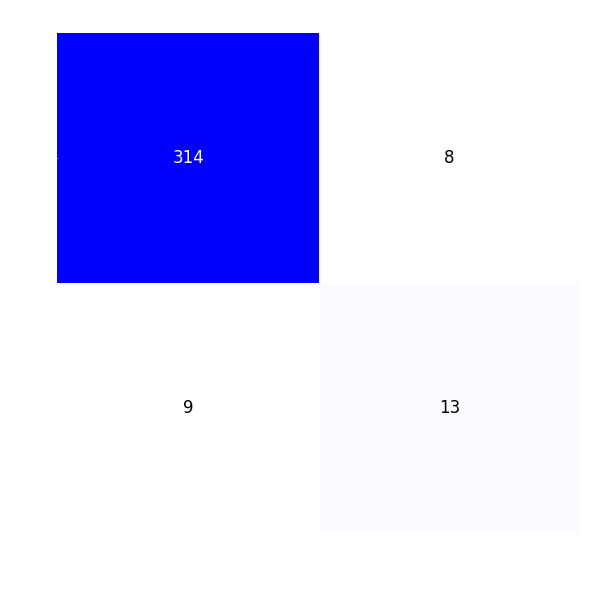

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

# Define a custom colormap that transitions from white to blue
blue_cmap = LinearSegmentedColormap.from_list("custom_blue", ["white", "blue"])

# Hyperparameter tuned confusion matrix (baseline plot removed)
cm_tuned = np.array([[314, 8],
                     [9,  13]])

def plot_confusion_matrix(cm, title, classes, cmap, save_path=None):
    """
    Plots a confusion matrix with a custom colormap and transparent background.
    Numeric annotations are dynamically colored: white on blue (darker) cells, 
    black on white (lighter) cells.

    Parameters:
      - cm: 2D numpy array for the confusion matrix.
      - title: Title for the plot.
      - classes: List of class labels for the axes.
      - cmap: Custom colormap.
      - save_path: If provided, saves the plot to the given path.
    """
    # Create a figure and axes
    fig, ax = plt.subplots(figsize=(6, 6))
    
    # Ensure transparent backgrounds
    fig.patch.set_alpha(0.0)
    ax.set_facecolor('none')
    
    # Plot the confusion matrix without annotations using seaborn
    sns.heatmap(cm, annot=False, fmt='d', cmap=cmap,
                xticklabels=classes, yticklabels=classes,
                cbar=False, ax=ax)
    
    # Retrieve the colormap and normalization from the plotted heatmap
    quadmesh = ax.collections[0]
    norm = quadmesh.norm
    current_cmap = quadmesh.cmap

    # Loop over the data dimensions to add text annotations
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            value = cm[i, j]
            # Normalize the value to get its color from the colormap
            normalized_val = norm(value)
            rgba = current_cmap(normalized_val)
            r, g, b, a = rgba

            # Compute brightness using the luminosity formula:
            # brightness = 0.299*r + 0.587*g + 0.114*b
            brightness = 0.299 * r + 0.587 * g + 0.114 * b

            # Use black text on lighter backgrounds (high brightness), white on dark backgrounds.
            # A threshold of 0.8 works well for a white-to-blue colormap.
            text_color = "black" if brightness > 0.8 else "white"
            ax.text(j + 0.5, i + 0.5, format(value, 'd'),
                    ha='center', va='center', color=text_color, fontsize=12)
    
    # Set title and axis labels with white text
    ax.set_title(title, color='white', fontsize=14)
    ax.set_xlabel('Predicted', color='white', fontsize=12)
    ax.set_ylabel('Actual', color='white', fontsize=12)
    
    # Set tick parameters and tick labels to white
    ax.tick_params(axis='both', colors='white')
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_color('white')
    
    # Set the color of the axis spines to white for a clean look
    for spine in ax.spines.values():
        spine.set_edgecolor('white')
    
    # Remove grid lines and apply a tight layout
    plt.grid(False)
    plt.tight_layout()
    
    # Save the figure if a save path is provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight', transparent=True)
    
    plt.show()

# Define the class labels
classes_common = ['non_irony', 'irony']

# Plot only the hyperparameter tuned confusion matrix with the blue colormap.
plot_confusion_matrix(cm_tuned, 
                      "Hyperparameter Tuned Confusion Matrix (Test Set)", 
                      classes_common, 
                      cmap=blue_cmap, 
                      save_path="../plots/tuned_cm_blue.png")
